# Neural Style Transfer


In [1]:
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import copy
from torchvision.utils import save_image


## Load Images

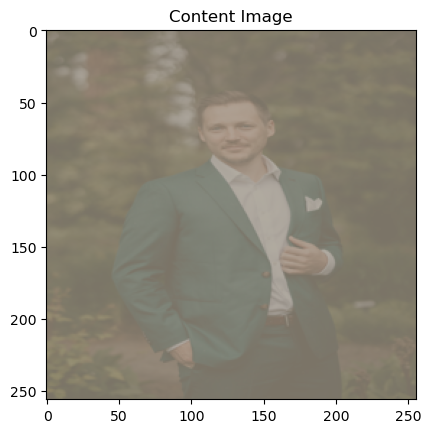

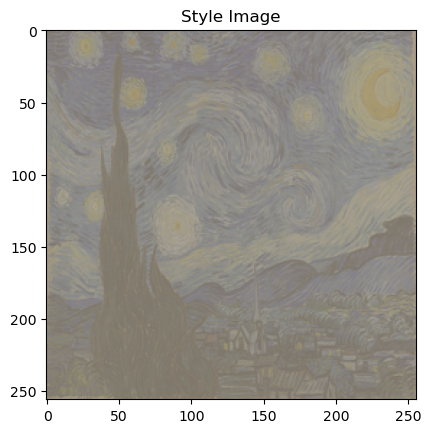

In [3]:
def load_image(img_path, max_size=512, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max_size:
        size = max(max(image.size), max_size)
    if shape:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
    
    image = in_transform(image)[:3, :, :].unsqueeze(0)
    
    return image

# Load your images
content = Image.open('content_image.jpg')
style = Image.open('style_image.jpg')

# Resize the images
new_size = (256, 256)  # Adjust this to your desired size
content = content.resize(new_size)
style = style.resize(new_size)

# Convert to Tensor
content = transforms.ToTensor()(content).unsqueeze(0)
style = transforms.ToTensor()(style).unsqueeze(0)

# Display images
def imshow(tensor, title=None):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    image = image.clip(0, 1)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

imshow(content, title="Content Image")
imshow(style, title="Style Image")


## Define the Model

In [4]:
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)


/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Define Content and Style Loss Functions

In [5]:
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '28': 'conv5_1'}
    
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# Calculate the Gram Matrix for each layer in the style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}


## Initialize Target Image

In [6]:
%config HistoryManager.enabled = False

target = content.clone().requires_grad_(True).to(device)


## Define the Style Transfer Process

In [7]:
if torch.cuda.is_available():
    target = target.cuda()
    vgg = vgg.cuda()


In [ ]:
# Define weights for each layer - adjust for different styles and effects
style_weights = {'conv1_1': 1.0, 'conv2_1': 0.75, 'conv3_1': 0.2, 'conv4_1': 0.2, 'conv5_1': 0.2}
content_weight = 1e3  # alpha
style_weight = 1e-2   # beta

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target = target.to(device)
vgg = vgg.to(device)

optimizer = optim.Adam([target], lr=0.003)

steps = 10  # choose the number of steps to run

for i in range(1, steps+1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_1'] - content_features['conv4_1']) ** 2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        b, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Save intermediate results
    if i % 2 == 0:
        save_image(target, f'output_step_{i}.png')


## Display the Final Output

In [ ]:
imshow(target, title="Final Image")
